In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.distributions.multivariate_normal import MultivariateNormal
import random
from tqdm import tqdm
from typing import Tuple, Dict, Optional, Callable, Type, Any
from IPython.display import clear_output

from Test_simulator import ThreeWheeledRobotSystem, Simulator
from PPO import FifoList, BatchSampler, RollingBatchSampler 
from PPO import EpisodicSampler, DataBuffer, Optimizer
from PPO import ModelPerceptron, ParallelPerceptrons
from PPO import Critic, GaussianPDFModel, Policy

import mlflow

In [2]:
class MonteCarloSimulationScenario:
    """Run whole REINFORCE procedure"""

    def __init__(
        self,
        simulator: Simulator,
        system: ThreeWheeledRobotSystem,
        policy: Policy,
        critic: Critic,
        N_episodes: int,
        N_iterations: int,
        discount_factor: float = 1.0,
        termination_criterion: Callable[
            [np.array, np.array, float, float], bool
        ] = lambda *args: False,
    ):
        """Initialize scenario for main loop


        Args:
            simulator (Simulator): simulator for computing system dynamics
            system (InvertedPendulumSystem): system itself
            policy (PolicyREINFORCE): REINFORCE gradient stepper
            N_episodes (int): number of episodes in one iteration
            N_iterations (int): number of iterations
            discount_factor (float, optional): discount factor for running costs. Defaults to 1
            termination_criterion (Callable[[np.array, np.array, float, float], bool], optional): criterion for episode termination. Takes observation, action, running_cost, total_cost. Defaults to lambda*args:False
        """

        self.simulator = simulator
        self.system = system
        self.policy = policy
        self.N_episodes = N_episodes
        self.N_iterations = N_iterations
        self.termination_criterion = termination_criterion
        self.discount_factor = discount_factor
        self.data_buffer = DataBuffer()
        self.critic = critic
        self.total_cost = 0
        self.total_costs_episodic = []
        self.learning_curve = []
        self.last_observations = None

    def compute_running_cost(self, observation: np.array, action: np.array) -> float:
        """Computes running cost

        Args:
            observation (np.array): current observation
            action (np.array): current action

        Returns:
            float: running cost value
        """

        return observation[0] ** 2 + observation[1] ** 2 + observation[2] ** 2

    def run(self) -> None:
        """Run main loop"""

        eps = 0.1
        means_total_costs = [eps]
        self.last_observation_interations = []
        for iteration_idx in range(self.N_iterations):
            if iteration_idx % 10 == 0:
                clear_output(wait=True)
            for episode_idx in tqdm(range(self.N_episodes)):
                terminated = False
                while self.simulator.step():
                    (
                        observation,
                        action,
                        step_idx,
                    ) = self.simulator.get_sim_step_data()

                    new_action = (
                        self.policy.model.sample(torch.tensor(observation).float())
                        .detach()
                        .cpu()
                        .numpy()
                    )
                    running_cost = self.compute_running_cost(observation, new_action)
                    discounted_running_cost = (
                        self.discount_factor ** (step_idx) * running_cost
                    )
                    self.total_cost += discounted_running_cost

                    if not terminated and self.termination_criterion(
                        observation,
                        new_action,
                        discounted_running_cost,
                        self.total_cost,
                    ):
                        terminated = True

                    if not terminated:
                        self.data_buffer.push_to_end(
                            observation=np.copy(observation),
                            action=np.copy(new_action),
                            observation_action=np.hstack((observation, action)),
                            running_cost=np.copy(running_cost),
                            discounted_running_cost=np.copy(discounted_running_cost),
                            total_cost=np.copy(self.total_cost),
                            step_id=step_idx,
                            episode_id=episode_idx,
                        )
                    self.system.receive_action(new_action)
                self.simulator.reset()
                self.total_costs_episodic.append(self.total_cost)
                self.total_cost = 0
            self.learning_curve.append(np.mean(self.total_costs_episodic))

            
            
            self.last_observations = pd.DataFrame(
                index=np.array(self.data_buffer.data["episode_id"]),
                data=np.array(self.data_buffer.data["observation"]),
            )
            self.last_actions = pd.DataFrame(
                index=np.array(self.data_buffer.data["episode_id"]),
                data=np.array(self.data_buffer.data["action"]),
            )

            mlflow.log_metric('Cost', np.mean(self.total_costs_episodic), step=iteration_idx)
            mlflow.log_metric('Grade_it', self.get_grade(), step=iteration_idx)
            
            self.critic.fit(self.data_buffer)
            self.policy.fit(self.data_buffer)

            means_total_costs.append(np.mean(self.total_costs_episodic))
            change = (means_total_costs[-1] / means_total_costs[-2] - 1) * 100
            sign = "-" if np.sign(change) == -1 else "+"
            print(
                f"Iteration: {iteration_idx + 1} / {self.N_iterations}, "
                + f"mean total cost {round(means_total_costs[-1], 2)}, "
                + f"% change: {sign}{abs(round(change,2))}, "
                + f"last observation: {self.last_observations.iloc[-1].values.reshape(-1)}",
                end="\n",
            )

            # --------------------------------------------------------------------------------------
            # Uncomment these lines if you want to stop the simulation when your system is stabilized
            # if self.get_grade() == 100:
            #     return
            # --------------------------------------------------------------------------------------

            self.total_costs_episodic = []

    def get_grade(self):
        metrics = np.max(
            np.abs(self.last_observations.loc[0].values[-10:].mean(axis=0).reshape(-1))
        )
        grade = round(100 - 100 * np.clip(metrics - 0.2, 0, 1))
        return grade

    def plot_data(self):
        """Plot learning results"""

        data = pd.Series(
            index=range(1, len(self.learning_curve) + 1), data=self.learning_curve
        )
        na_mask = data.isna()
        not_na_mask = ~na_mask
        interpolated_values = data.interpolate()
        interpolated_values[not_na_mask] = None
        data.plot(marker="o", markersize=3)
        interpolated_values.plot(linestyle="--")

        plt.title("Total cost by iteration")
        plt.xlabel("Iteration number")
        plt.ylabel("Total cost")
        # plt.yscale("log")
        plt.show()

        x_ax, y_ax, angle_ax = pd.DataFrame(
            data=self.last_observations.loc[0].values
        ).plot(
            xlabel="Step Number",
            title="Observations in last iteration",
            legend=False,
            subplots=True,
            grid=True,
        )
        x_ax.set_ylabel("x")
        y_ax.set_ylabel("y")
        angle_ax.set_ylabel("angle")

        force_ax, angle_action_ax = pd.DataFrame(
            data=self.last_actions.loc[0].values
        ).plot(
            xlabel="Step Number",
            title="Actions in last iteration",
            legend=False,
            subplots=True,
            grid=True,
        )
        force_ax.set_ylabel("speed")
        angle_action_ax.set_ylabel("angle speed")

        plt.show()

        print("-----------------------------------------------------")
        grade = self.get_grade()
        if grade == 100:
            print("Environment solved! Grade: 100%")
        else:
            print(f"You can do better! Grade: {grade}%")

    def return_plots(self):
        
        fig_actions_li, ax_li = plt.subplots(2)
        data_actions = self.last_actions.loc[0].values
        # print(data_actions.shape)
        steps = np.arange(len(data_actions))
        ax_li[0].plot(steps, data_actions[:, 0])
        # ax_li[0].set_xlabel("Step Number")
        ax_li[0].set_ylabel("Speed")
        ax_li[0].set_title("Actions in last iterations")

        ax_li[1].plot(steps, data_actions[:, 1], c='orange')
        ax_li[1].set_xlabel("Step Number")
        ax_li[1].set_ylabel("Angle Speed")
        # ax_li[1].set_title("Actions in last iterations")

        fig_obsevations_li, ax_observations_li = plt.subplots(3)
        observations = self.last_observations.loc[0].values
        steps = np.arange(len(observations))
        ax_observations_li[0].plot(steps, observations[:, 0])
        ax_observations_li[0].set_ylabel("x")
        ax_observations_li[0].set_title("Observations in last iteration")

        ax_observations_li[1].plot(steps, observations[:, 1], c='orange')
        ax_observations_li[1].set_ylabel("y")

        ax_observations_li[2].plot(steps, observations[:, 2], c='green')
        ax_observations_li[2].set_xlabel("Step Number")
        ax_observations_li[2].set_ylabel("Angle")

        fig_costs, ax_cost = plt.subplots(1)
        
        # data = pd.Series(
            # index=range(1, len(self.learning_curve) + 1), data=self.learning_curve
        # )
        # na_mask = data.isna()
        # not_na_mask = ~na_mask
        # interpolated_values = data.interpolate()
        # interpolated_values[not_na_mask] = None
        # data.plot(marker="o", markersize=3)
        # interpolated_values.plot(linestyle="--")
        iterations = np.arange(len(self.learning_curve))
        # print("Interpolated values: ", interpolated_values, iterations)
        # print("Learning_curve:", self.learning_curve)

        ax_cost.plot(iterations, self.learning_curve)

        
        ax_cost.set_title("Total cost by iteration")
        ax_cost.set_xlabel("Iteration number")
        ax_cost.set_ylabel("Total cost")
        

        return fig_actions_li, fig_obsevations_li, fig_costs
        

        
        
        # axs[0].plot(x0, y0)
        # axs[1].plot(x1, y1)
        # mlflow.log_figure(fig, 'my_plot.png')

100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.04s/it]


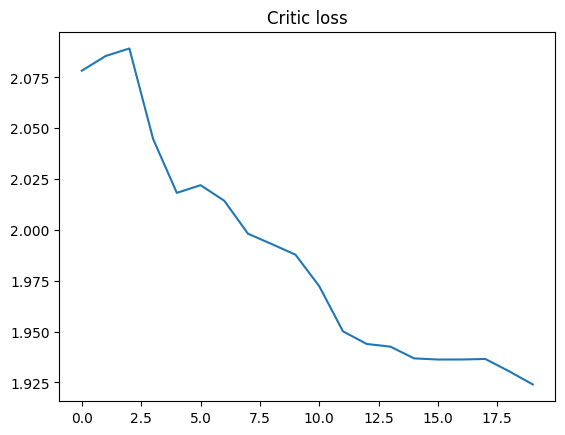

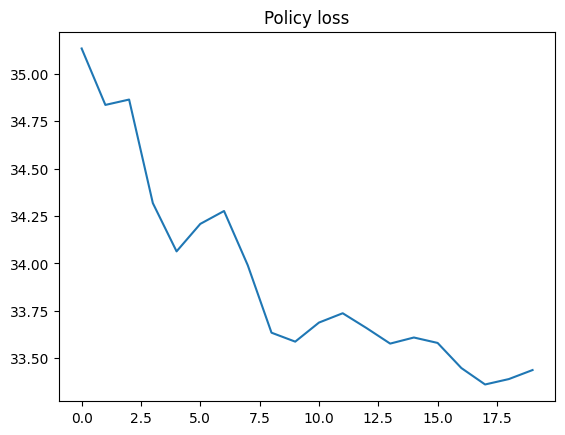

Iteration: 141 / 150, mean total cost 3878.26, % change: -3.77, last observation: [ 0.09452217 -0.12854463 -0.09065051]


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.04s/it]


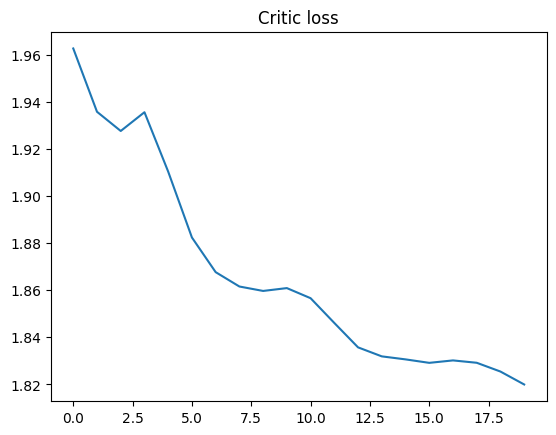

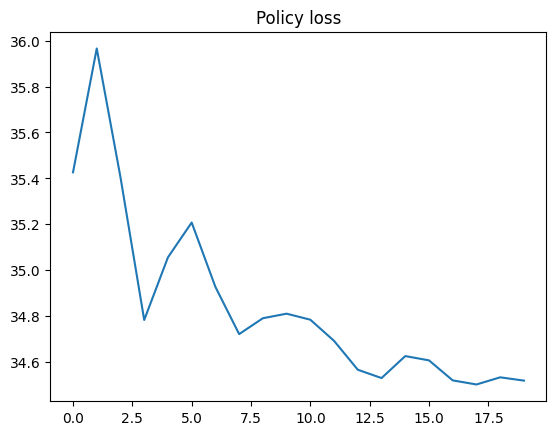

Iteration: 142 / 150, mean total cost 3951.1, % change: +1.88, last observation: [ 0.08976327  0.04599091 -0.12997803]


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.07s/it]


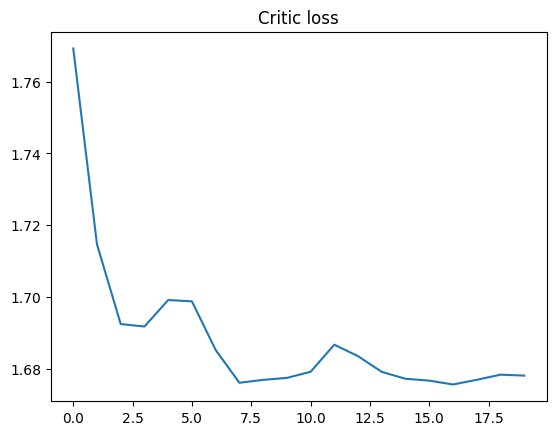

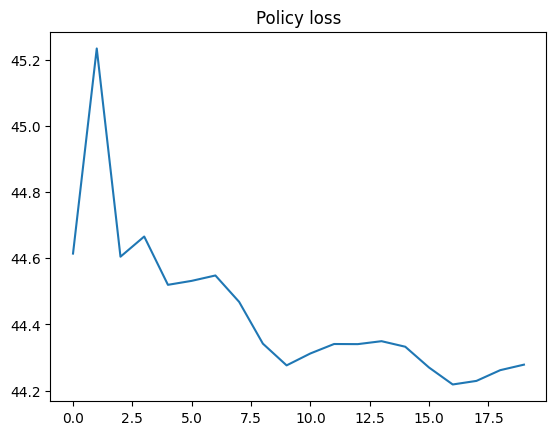

Iteration: 143 / 150, mean total cost 3924.37, % change: -0.68, last observation: [ 0.03513387 -0.07334548 -0.11386811]


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.04s/it]


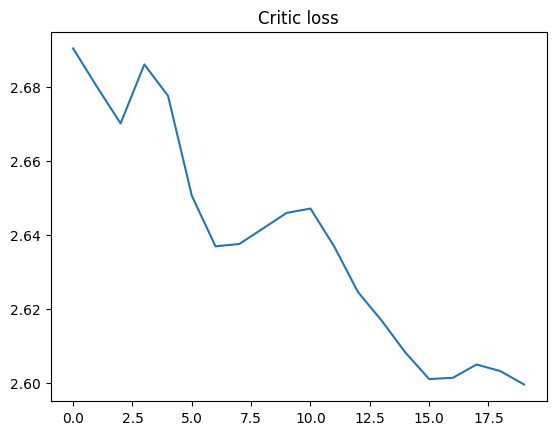

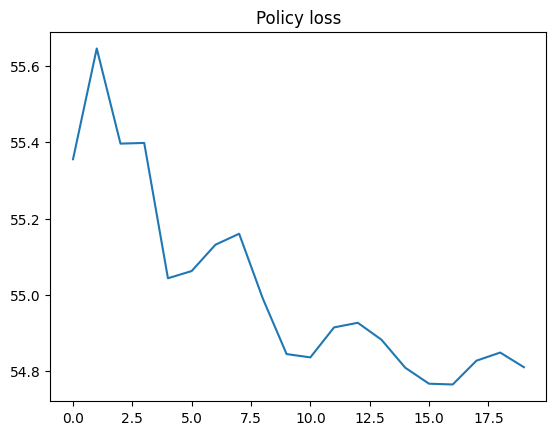

Iteration: 144 / 150, mean total cost 4027.67, % change: +2.63, last observation: [ 0.09863649 -0.10166795 -0.07752738]


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/it]


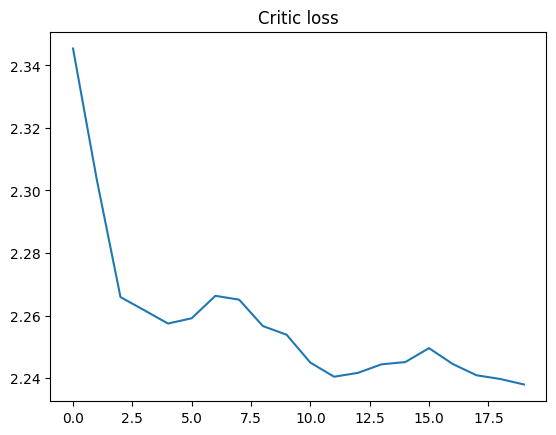

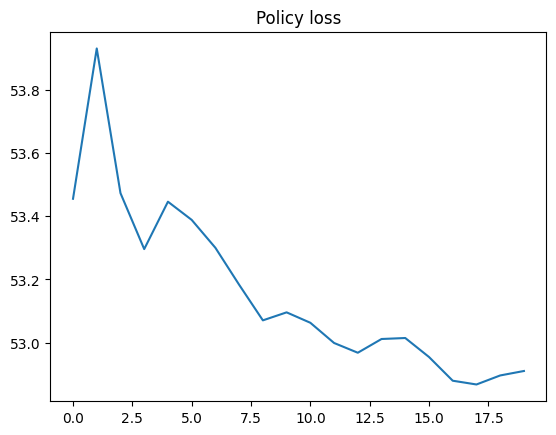

Iteration: 145 / 150, mean total cost 4012.48, % change: -0.38, last observation: [ 0.08037064 -0.07059055 -0.09037005]


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.04s/it]


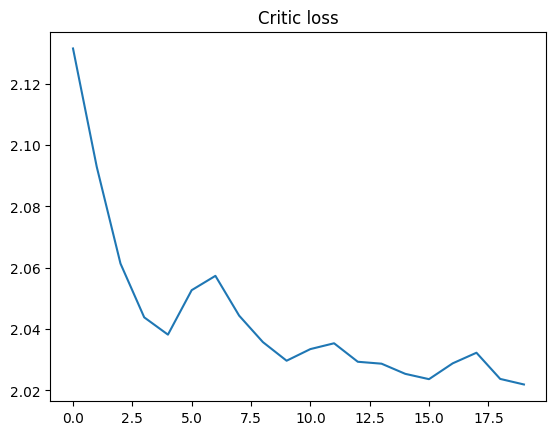

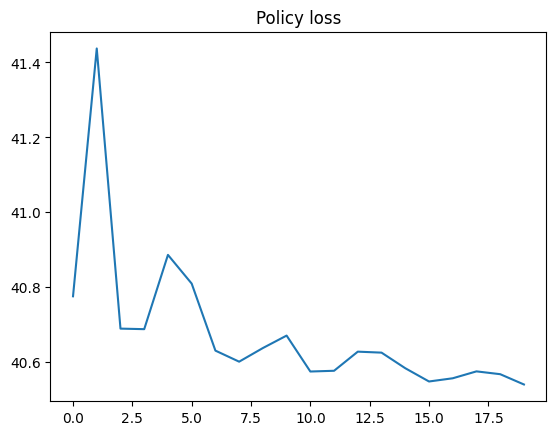

Iteration: 146 / 150, mean total cost 3971.86, % change: -1.01, last observation: [ 0.06996023 -0.02938187 -0.08545634]


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.07s/it]


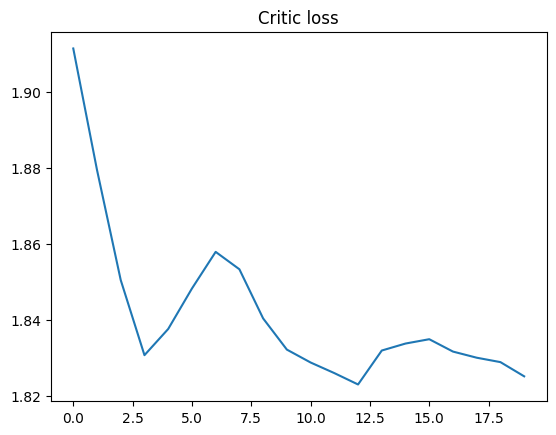

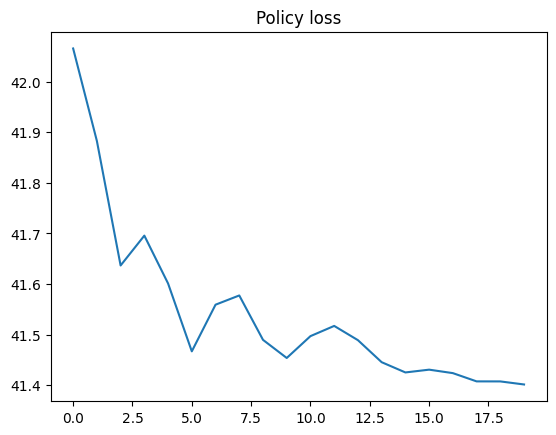

Iteration: 147 / 150, mean total cost 3922.23, % change: -1.25, last observation: [ 0.0573959  -0.01409007 -0.09449347]


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.04s/it]


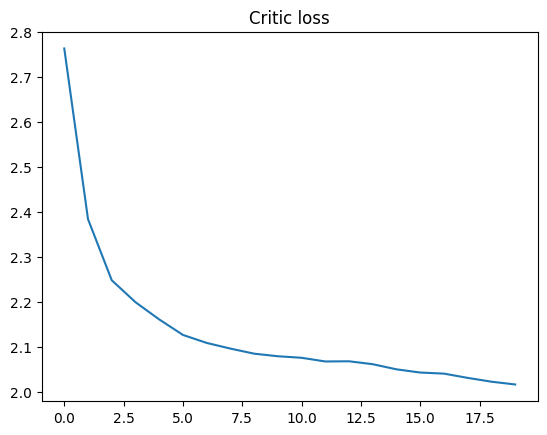

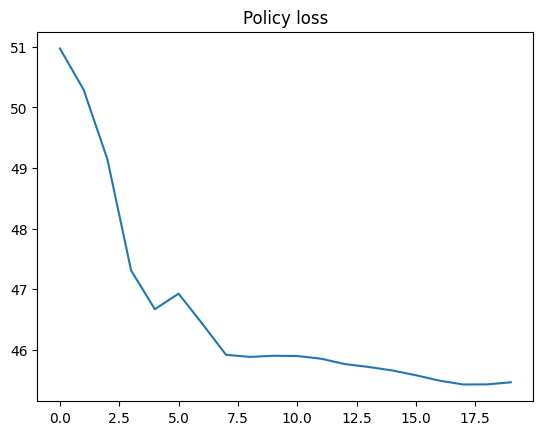

Iteration: 148 / 150, mean total cost 3987.11, % change: +1.65, last observation: [ 0.01944831  0.14444288 -0.11089486]


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.04s/it]


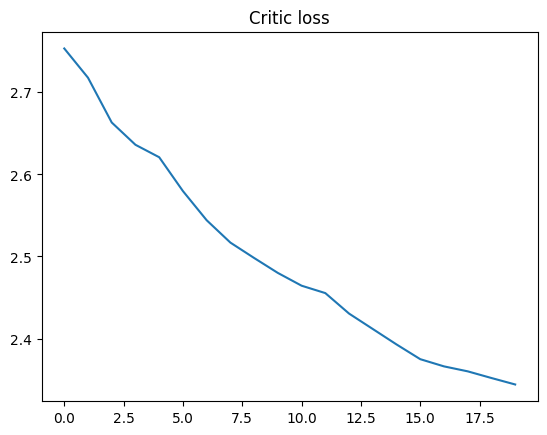

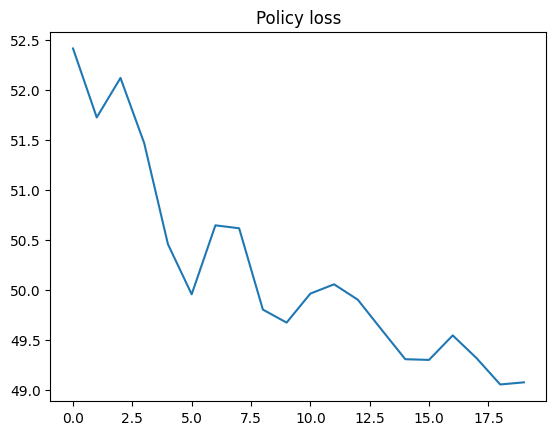

Iteration: 149 / 150, mean total cost 3895.9, % change: -2.29, last observation: [ 0.16051952 -0.04140855 -0.01509149]


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.04s/it]


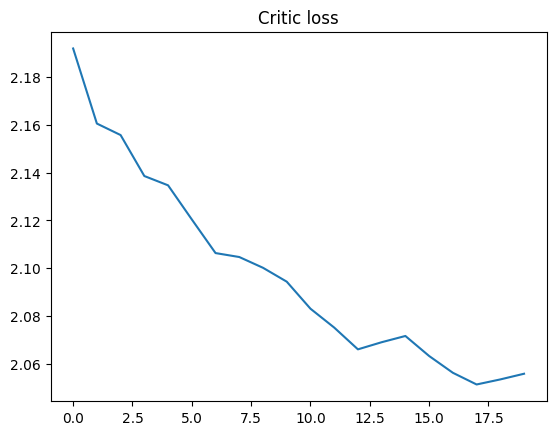

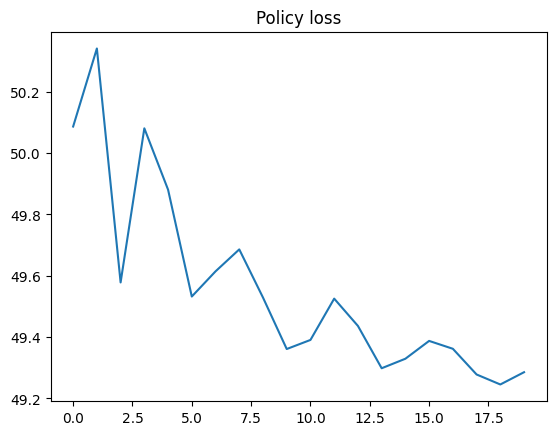

Iteration: 150 / 150, mean total cost 3920.23, % change: +0.62, last observation: [ 0.09637685 -0.08062761 -0.02349184]


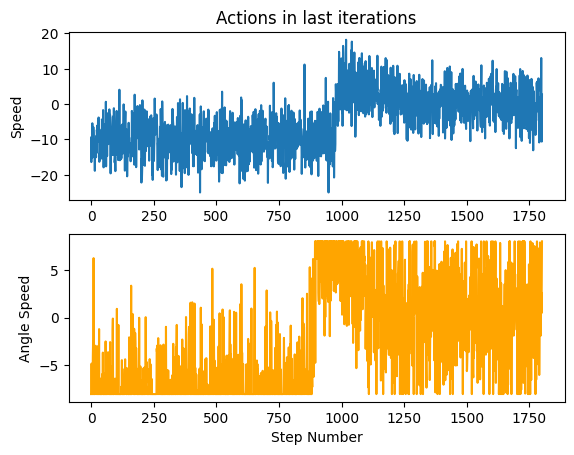

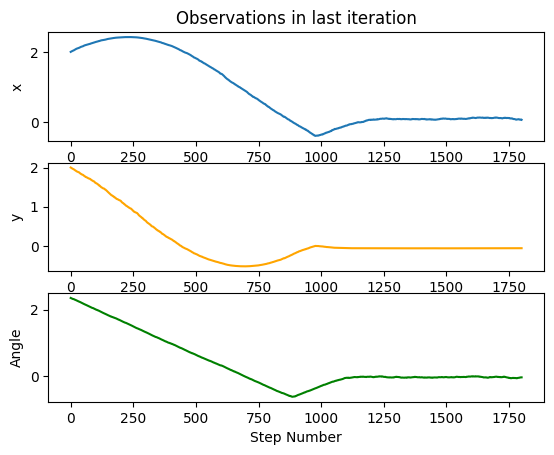

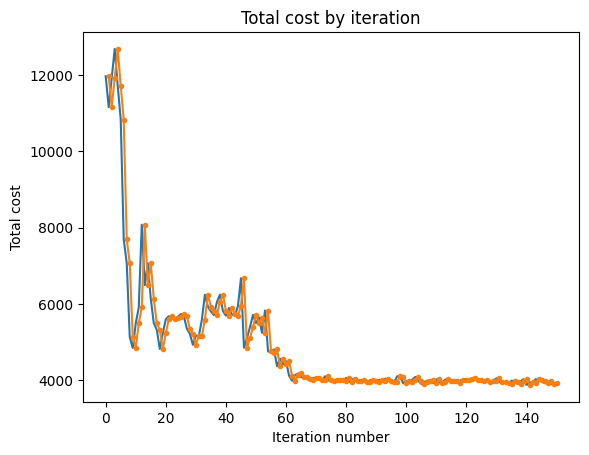

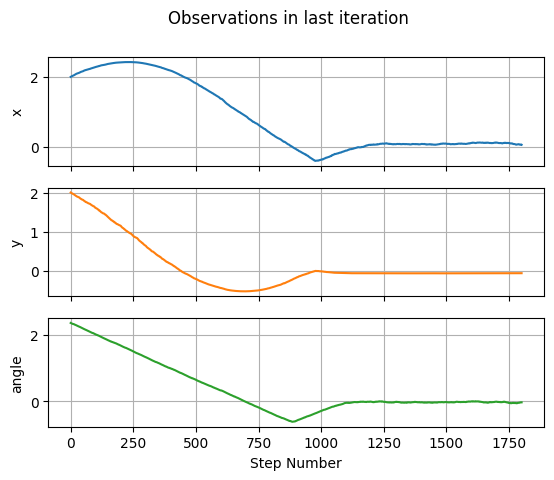

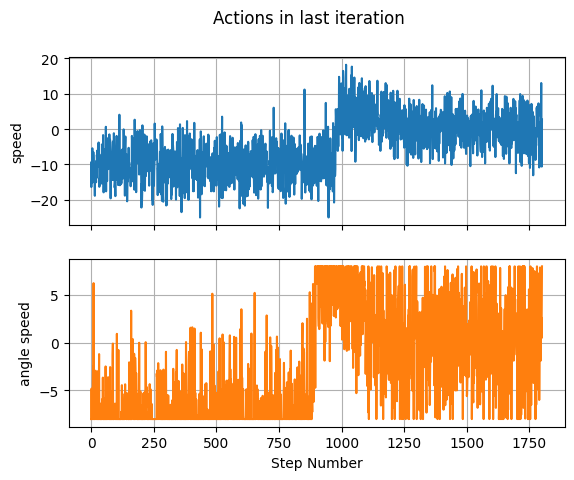

-----------------------------------------------------
Environment solved! Grade: 100%


In [4]:
SEED = 14
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

system = ThreeWheeledRobotSystem()
## DO NOT CHANGE THE PARAMS OF SIMULATOR.
simulator = Simulator(
    system,
    N_steps=1800,
    step_size=0.0005,
    state_init=np.array([2.0, 2.0, 3 * np.pi / 4]),
)
# ---------------------------------------------------------------------------
# YOUR CODE GOES HERE
discount_factor = 0.999  # you can change it, but it is not recommended
# ---------------------------------------------------------------------------

model = GaussianPDFModel(
    dim_observation=system.dim_observation,
    dim_action=system.dim_action,
    action_bounds=np.array([[-25, 25], [-8, 8]]),
    # ---------------------------------------------------------------------------
    # YOUR CODE GOES HERE
    n_hidden_layers=2,  # TRY TO FIND n_hidden_layers empirically
    scale_factor=1,  # TRY TO FIND scale_factor EMPIRICALLY
    dim_hidden=100,  # TRY TO FIND dim_hidden EMPIRICALLY
    std=0.2,  # TRY TO FIND std EMPIRICALLY
    # ---------------------------------------------------------------------------
)
critic_model = ModelPerceptron(
    dim_input=system.dim_observation,
    dim_output=1,
    # --------------------------------------------------------------------------
    # YOUR CODE GOES HERE
    dim_hidden=100,  # TRY TO FIND dim_hidden EMPIRICALLY
    n_hidden_layers=2,  # TRY TO FIND n_hidden_layers EMIRICALLY
    # --------------------------------------------------------------------------
)

critic_optimizer = Optimizer(
    model=critic_model,
    opt_method=torch.optim.Adam,
    # ---------------------------------------------------------------------------
    # YOUR CODE GOES HERE
    opt_options=dict(lr=0.001),  # TRY TO FIND lr EMPIRICALLY
    n_epochs=20,  # TRY TO FIND n_epochs EMPIRICALLY
    # ---------------------------------------------------------------------------
    is_reinstantiate_optimizer=True,  # we reinstantiate optimizer before every
    # optimization procedure to guarantee
    # that Adam doesn't remeber previous gradients
)

critic = Critic(
    # ---------------------------------------------------------------------------
    # YOUR CODE GOES HERE
    td_n=2,  # TRY TO FIND td_n EMPIRICALLY
    # ---------------------------------------------------------------------------
    discount_factor=discount_factor,
    device="cpu",
    model=critic_model,
    optimizer=critic_optimizer,
)


policy_optimizer = Optimizer(
    model=model,
    opt_method=torch.optim.Adam,
    # ---------------------------------------------------------------------------
    # YOUR CODE GOES HERE
    opt_options=dict(lr=0.0012),  # TRY TO FIND lr EMPIRICALLY
    n_epochs=20, # TRY TO FIND n_epochs EMPIRICALLY
    # ---------------------------------------------------------------------------
    is_reinstantiate_optimizer=True,
)
## Or if you want to use scheduler then initialize optimizer, via, for instance
# lr_scheduler_fading_coeff = 1
# optimizer = Optimizer(
#     model=model,
#     opt_method=torch.optim.Adam,
#     opt_options=dict(lr=1.0, betas=(0.8, 0.9)),
#     shuffle=False,
#     lr_scheduler_method=torch.optim.lr_scheduler.MultiplicativeLR,
#     lr_scheduler_options={
#         "lr_lambda": lambda iteration: 1
#         / np.sqrt((iteration / lr_scheduler_fading_coeff) ** 2 + 1)
#     },
#     lr_scheduler_switch=LRSchedulerSwitch(norm_observation_threshold=0.1),
# )
#
# BELEIVE US! YOU CAN SOLVE THIS TASK WITHOUT SCHEDULER

policy = Policy(
    model,
    policy_optimizer,
    critic=critic,
    device="cpu",
    discount_factor=discount_factor,
    # ---------------------------------------------------------------------------
    # YOUR CODE GOES HERE
    epsilon=0.2,  # authors advice using 0.2, but you can change it
    # --------------------------------------------------------------------------
)


# This termination criterion never terminates episodes
trivial_terminantion_criterion = lambda *args: False

## EXAMPLE. This termination criterion terminates episode if observation norm >= 20
#
# termination_criterion = (
#     lambda observation, action, running_cost, total_cost: (
#         np.linalg.norm(observation) >= 20
#     )
# )
#
# DO NOT USE TERMINATION CRITERION OTHER THAN trivial_termination_criterion


scenario = MonteCarloSimulationScenario(
    simulator=simulator,
    system=system,
    policy=policy,
    critic=critic,
    # ---------------------------------------------------------------------------
    # YOUR CODE GOES HERE
    N_episodes=2,  # Increasing the number of episodes stabilizes learning
    N_iterations=150,  # You can change the number of iterations if you want
    # ---------------------------------------------------------------------------
    termination_criterion=trivial_terminantion_criterion,
    discount_factor=discount_factor,
)

# defining a new experiment
experiment_name = 'ppo_hw'
exp_id = mlflow.set_experiment(experiment_name=experiment_name)

with mlflow.start_run():
    # Logging params and metrics to MLFlow
    mlflow.log_param('model_n_hidden_layers', model.n_hidden_layers)
    mlflow.log_param('model_dim_hidden', model.dim_hidden)
    mlflow.log_param('model_std', model.std)
    mlflow.log_param('critic_model_dim_hidden', critic_model.dim_hidden)
    mlflow.log_param('critic_model_n_hidden_layers', critic_model.n_hidden_layers)
    mlflow.log_param('critic_optimizer_lr', critic_optimizer.opt_options["lr"])
    mlflow.log_param('critic_optimizer_n_epochs', critic_optimizer.n_epochs)
    mlflow.log_param('critic_td_n', critic.td_n)
    mlflow.log_param('policy_optimizer_lr', policy_optimizer.opt_options["lr"])
    mlflow.log_param('policy_optimizer_n_epoches', policy_optimizer.n_epochs)
    mlflow.log_param('discount_factor', discount_factor)
    mlflow.log_param('scenario_N_episodes', scenario.N_episodes)
    mlflow.log_param('scenario_N_iterations', scenario.N_iterations)
    
    try:
        scenario.run()
    except KeyboardInterrupt:
        clear_output(wait=True)
        # scenario.plot_data()

    # for i, cost in enumerate(scenario.learning_curve):
    #     mlflow.log_metric('Cost', cost, step=i)
    mlflow.log_metric('Grade', scenario.get_grade())
    fig_actions, fig_observations, fig_cost = scenario.return_plots()
    mlflow.log_figure(fig_actions, 'actions.png')
    mlflow.log_figure(fig_observations, 'observations.png')
    mlflow.log_figure(fig_cost, 'cost.png')

    # get plots
    # mlflow.log_metric('rmse_train', rmse_train)
    
    # clear_output(wait=True)
    scenario.plot_data()